#Import Dependencies


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import requests
import gc
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


#Checking GPU availability

In [18]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print("CUDA is available" if torch.cuda.is_available else "CUDA is NOT available!")

CUDA is available


#Loading and Reshaping the Image

In [19]:
def load_image(img_path, shape=None):
    """
    Load and preprocess an image.

    Args:
        img_path (str): Path to the image file or URL.
        shape (int, optional): Desired size for the image.

    Returns:
        torch.Tensor: Preprocessed image tensor.
    """
    try:
        if "http" in img_path:
            response = requests.get(img_path)
            response.raise_for_status()  # Check for HTTP request errors
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

    # Determine the size for resizing
    max_size = max(image.size)
    target_size = shape if shape is not None else min(max_size, 512)

    # Define the transformation pipeline
    loader = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    #Values based on mean and standard deviation of RGB on the basis of ImageNet Dataset

    # Apply transformations and add batch dimension
    image_tensor = loader(image).unsqueeze(0)

    return image_tensor


In [20]:
def show_image(tensor):
    """
    Convert a normalized image tensor back to a NumPy array for visualization.

    Args:
        tensor (torch.Tensor): Normalized image tensor.

    Returns:
        np.ndarray: NumPy array representing the image.
    """
    # Ensure the tensor is on the CPU and detached from the computation graph
    image = tensor.to("cpu").clone().detach()

    # Convert the tensor to a NumPy array
    image = image.numpy()

    # If the tensor has a batch dimension, remove it
    if image.shape[0] == 1:
        image = image.squeeze(0)

    # Rearrange dimensions if necessary
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)

    # Denormalize the image by reversing the normalization process
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip values to be in the valid range [0, 1]
    image = np.clip(image, 0, 1)

    return image



In [21]:
def display_images(content, style, title1='Content Image', title2='Style Image'):
    """
    Display two images side by side.

    Args:
        content (np.ndarray): NumPy array representing the content image.
        style (np.ndarray): NumPy array representing the style image.
        title1 (str): Title for the first image.
        title2 (str): Title for the second image.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(content)
    ax1.set_title(title1)
    ax1.axis('off')

    ax2.imshow(style)
    ax2.set_title(title2)
    ax2.axis('off')

    plt.show()




#Visualising the Content and Style Image

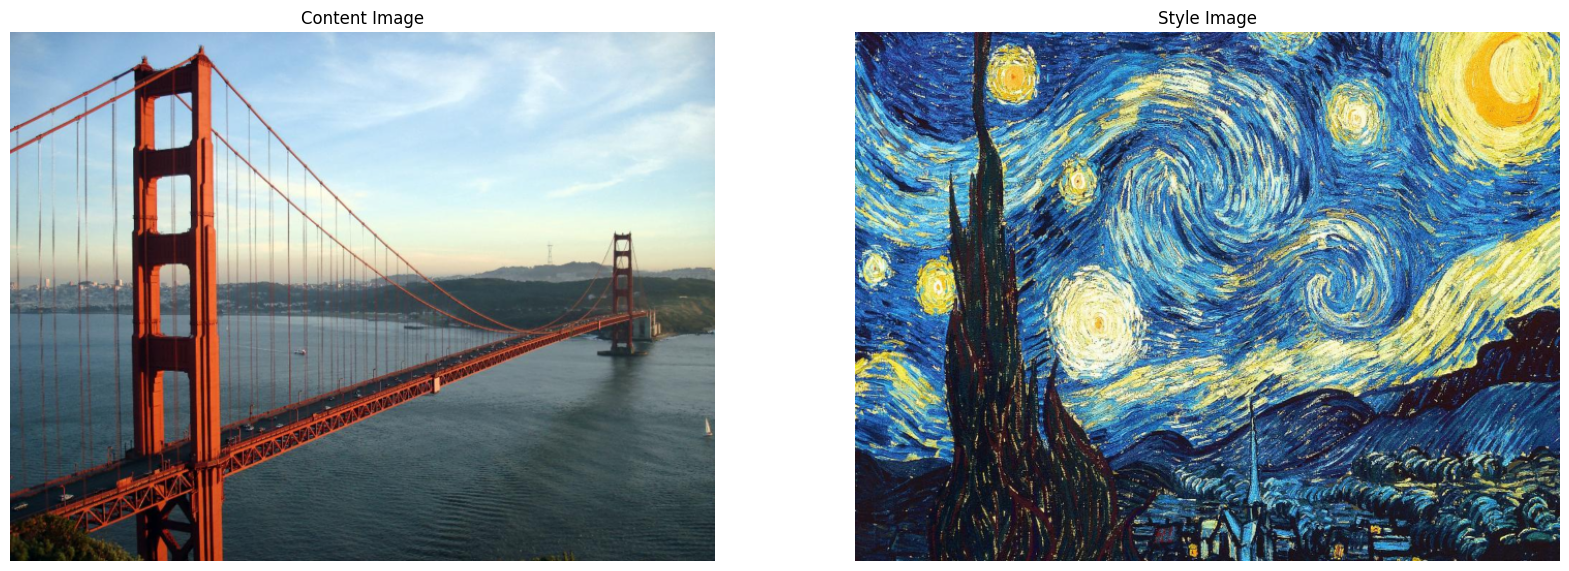

In [22]:
content = load_image('/content/golden_gate.jpg').to(device)
style = load_image('/content/starry_night.jpg', shape=content.shape[-2:]).to(device)
# Assuming content and style are NumPy arrays
content_image = show_image(content)
style_image = show_image(style)

display_images(content_image, style_image)

#Importing Pretrained Model

In [23]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

#Extract Feature and Compute Gram Matrix

In [24]:
def get_features(image, model, layers=None):
    """
    Extracts features from the specified layers of a given model.

    Args:
        image (torch.Tensor): Input image tensor.
        model (torch.nn.Module): Feature extraction model.
        layers (dict): Dictionary specifying layers to extract features from.

    Returns:
        dict: Dictionary containing features from the specified layers.
    """
    model.eval()  # Set the model to evaluation mode

    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

def gram_matrix(tensor):
    """
    Computes the Gram matrix of a given tensor.

    Args:
        tensor (torch.Tensor): Input tensor.

    Returns:
        torch.Tensor: Gram matrix of the input tensor.
    """
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


#Neural Style Transfer Configuration Block

In [27]:
# Get content and style features
content_features = get_features(content,vgg)
style_features = get_features(style,vgg)

# Compute style Gram matrices
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a target image tensor for optimization
target = content.clone().requires_grad_(True).to(device)

# Define style and content weights
weights = {
    'conv1_1': {'content': 1.0, 'style': 1.0},
    'conv2_1': {'content': 0.9, 'style': 0.9},
    'conv3_1': {'content': 0.2, 'style': 0.2},
    'conv4_1': {'content': 0.2, 'style': 0.2},
    'conv5_1': {'content': 0.2, 'style': 0.2}
}

# Define alpha (content weight) and beta (style weight)
content_weight = 1
style_weight = 1e6


#Clean Memory Before Running your model

In [28]:
for i in range(5):
    gc.collect()
    torch.cuda.empty_cache()

#Neural Style Transfer Training Loop

 total loss =  14062.9189453125


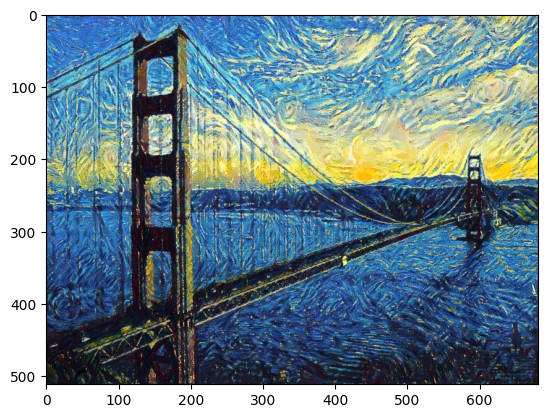

 total loss =  13942.4609375


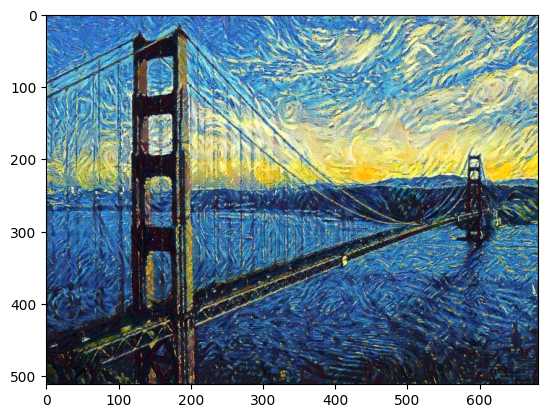

 total loss =  15950.087890625


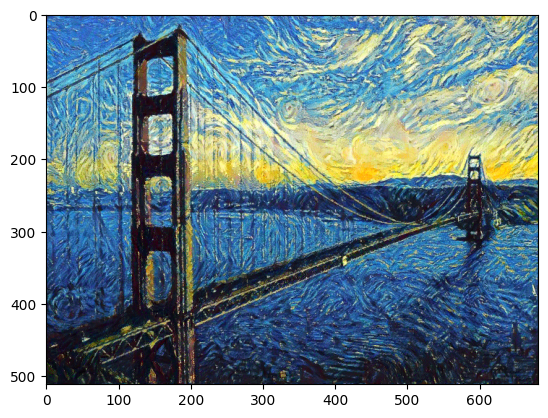

 total loss =  13767.7724609375


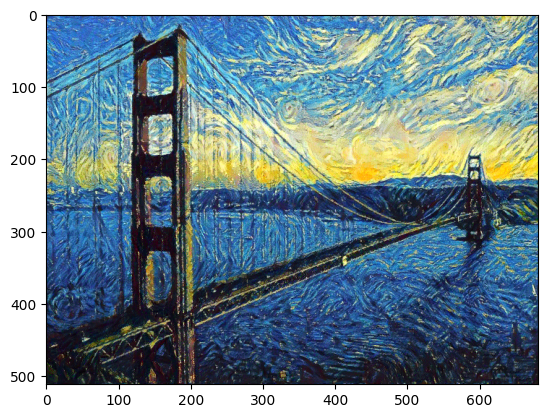

 total loss =  13735.4453125


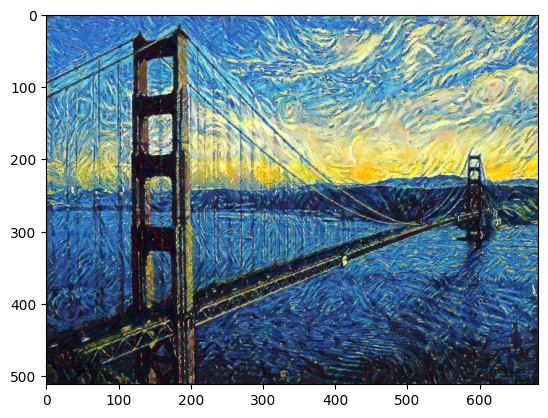

 total loss =  14303.5361328125


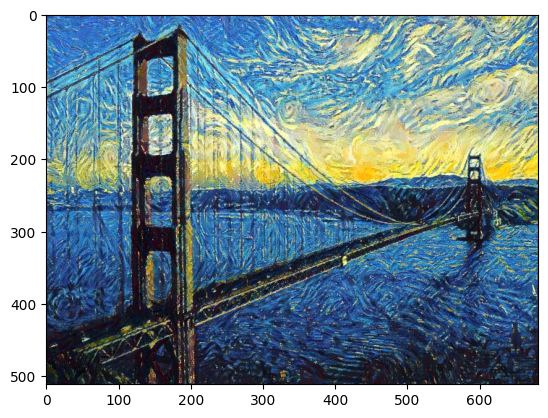

 total loss =  13714.2802734375


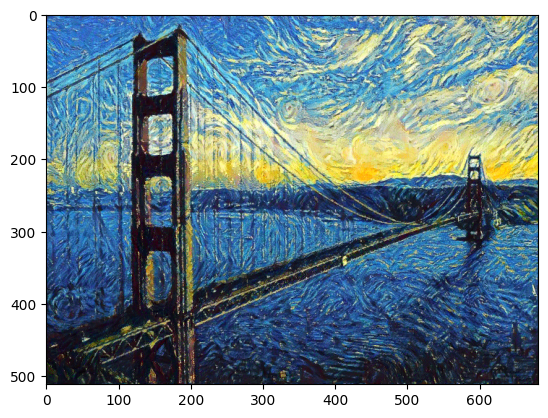

KeyboardInterrupt: ignored

In [31]:
show_every = 800
steps = 40000

losses = {'content': [],
          'style' : [],
          'total' : []
         }

optimizer = optim.Adam([target], lr=0.003)

for i in range(1, steps+1):

    target_features = get_features(target,vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0

    for layer in style_weights:

        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)

        _, d, h, w = target_feature.shape

        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

#     losses['content'].append(content_loss.item())
#     losses['style'].append(style_loss.item())
#     losses['total'].append(total_loss.item())

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % show_every == 0:
        print(' total loss = ', total_loss.item())
        plt.imshow(show_image(target))
        plt.show()